**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. **Use JupyterLab**. Other notebook-editing software (e.g. VSCode, pycharm) might corrupt the notebook files.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

# Local Feature Matching

In this notebook we want to match features from images showing the same object. This is at the core of applications such as panorama stitching.

A quick overview:

1. We will first detect keypoints in images using the Harris detector.
2. Then weuse simple histogram descriptors to describe the neighborhood of each keypoint.
3. Finally we will compare descriptors from different images using a distance function and establish matching points.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import math
from scipy import ndimage
#from attrdict import AttrDict
from mpl_toolkits.mplot3d import Axes3D

# Many useful functions
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
        
def load_image(f_name):
    return imageio.imread(f_name, mode='F').astype(np.float32)/255

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def gauss(x, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(- x**2 / 2 / sigma**2)

def gaussdx(x, sigma):
    return (-1 / np.sqrt(2 * np.pi) / sigma**3 * x *
            np.exp(- x**2 / 2 / sigma**2))

def gauss_derivs(image, sigma):
    kernel_radius = np.ceil(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    image_dx = convolve_with_two(image, D, G.T)
    image_dy = convolve_with_two(image, G, D.T)
    return image_dx, image_dy

def gauss_filter(image, sigma):
    kernel_radius = np.ceil(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, sigma)
    return convolve_with_two(image, G, G.T)

def draw_keypoints(image, points):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    radius = image.shape[1]//100+1
    for x, y in points:
        cv2.circle(image, (int(x), int(y)), radius, (1, 0, 0), thickness=2)        
    return image

def random_colors(n_colors):
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, n_colors)
    colors = plt.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return colors*255

colors = random_colors(1000)

def draw_point_matches(im1, im2, point_matches):
    result = np.concatenate([im1, im2], axis=1)
    result = (result.astype(float)*0.6).astype(np.uint8)
    im1_width = im1.shape[1]
    for (x1, y1, x2, y2), color in zip(point_matches, colors):
        cv2.line(result, (x1, y1), (im1_width+x2, y2), 
                 color=color, thickness=2, lineType=cv2.LINE_AA)
    return result

#  Harris Detector

The Harris detector searches for points, around which the second-moment matrix $M$ of the gradient vector has two large eigenvalues (This $M$ is denoted by $C$ in the Grauman & Leibe script). This matrix $M$ can be written as:

$$
M(\sigma, \tilde{\sigma}) = G(\tilde{\sigma}) \star \left[\begin{matrix} I_x^2(\sigma) & I_x(\sigma) \cdot I_y(\sigma) \cr I_x(\sigma)\cdot I_y(\sigma) & I_y^2(\sigma) \end{matrix}\right]
$$

Note that the matrix $M$ is computed for each pixel (we omitted the $x, y$ dependency in this formula for clarity). In the above notation the 4 elements of the second-moment matrix are considered as full 2D "images" (signals) and each of these 4 "images" are convolved with the Gaussian $G(\tilde{\sigma})$ independently. We have two sigmas $\sigma$ and $\tilde{\sigma}$ here for two different uses of Gaussian blurring:

  * first for computing the derivatives themselves (as derivatives-of-Gaussian) with $\sigma$, and
  * then another Gaussian with $\tilde{\sigma}$ that operates on "images" containing the *products* of the derivatives (such as $I_x^2(\sigma)$) in order to collect summary statistics from a window around each point.

Instead of explicitly computing the eigenvalues $\lambda_1$ and $\lambda_2$ of $M$, the following equivalences are used:

$$
\det(M) = \lambda_1 \lambda_2 = (G(\tilde{\sigma}) \star I_x^2)\cdot (G(\tilde{\sigma}) \star I_y^2) - (G(\tilde{\sigma}) \star (I_x\cdot I_y))^2
$$

$$
\mathrm{trace}(M) = \lambda_1 + \lambda_2 = G(\tilde{\sigma}) \star I_x^2 + G(\tilde{\sigma}) \star I_y^2
$$

The Harris criterion is then:

$$
\det(M) - \alpha \cdot \mathrm{trace}^2(M) > t
$$

In practice, the parameters are usually set as $\tilde{\sigma} = 2 \sigma, \alpha=0.06$.
Read more in Section 3.2.1.2 of the Grauman & Leibe script (grauman-leibe-ch3-local-features.pdf in the Moodle).

----

Write a function `harris_score(im, sigma1, sigma2, alpha)` which:
  - computes the values of $M$ **for each pixel** of the grayscale image `im`
  - calculates the trace and the determinant at each pixel
  - combines them to the Harris response and returns the resulting image

In [20]:
# POINTS: 4

def harris_scores(im, sigma1, sigma2, alpha):
    dx, dy = gauss_derivs(im, sigma1)
    
    # YOUR CODE HERE
  
    # Compute the elements of the Harris matrix M
    Ixx = cv2.GaussianBlur(dx**2, (0, 0), sigma2)
    Iyy = cv2.GaussianBlur(dy**2, (0, 0), sigma2)
    Ixy = cv2.GaussianBlur(dx * dy, (0, 0), sigma2)
    
    # Calculate the determinant and trace of the Harris matrix M
    detM = Ixx * Iyy - Ixy**2
    traceM = Ixx + Iyy
    
    # Calculate the Harris response
    scores = detM - alpha * (traceM ** 2)
    #raise NotImplementedError()
    return scores

Furthermore, implement `nms(scores)` to perform non-maximum suppression of the response image. A score is dropped if its smaller than any of its 8 neighbors.

In [21]:
# POINTS: 3

def nms(scores):
    """Non-maximum suppression"""
    # YOUR CODE HERE
    scores_out = np.zeros_like(scores)
    rows, cols = scores.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Extract the 3x3 neighborhood
            neighborhood = scores[i-1:i+2, j-1:j+2]
            center_value = scores[i, j]
            
            # Check if the center value is the maximum in the neighborhood
            if center_value == np.max(neighborhood):
                scores_out[i, j] = center_value
    #raise NotImplementedError()
    return scores_out

Look at `score_map_to_keypoints(scores, score_threshold)`. It takes a score map and returns an array of shape `[number_of_corners, 2]`, with each row being the $(x,y)$ coordinates of a found keypoint. We use `score_threshold` as the threshold for considering a point to be a keypoint. (This is quite similar to how we found detections from score maps in the sliding-window detection exercise.)

In [23]:
def score_map_to_keypoints(scores, score_threshold):
    corner_ys, corner_xs = (scores > score_threshold).nonzero()
    return np.stack([corner_xs, corner_ys], axis=1)

Now check the score maps and keypoints:

C:\Users\lenih\AppData\Local\Temp\ipykernel_36156\2841493670.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(f_name, mode='F').astype(np.float32)/255


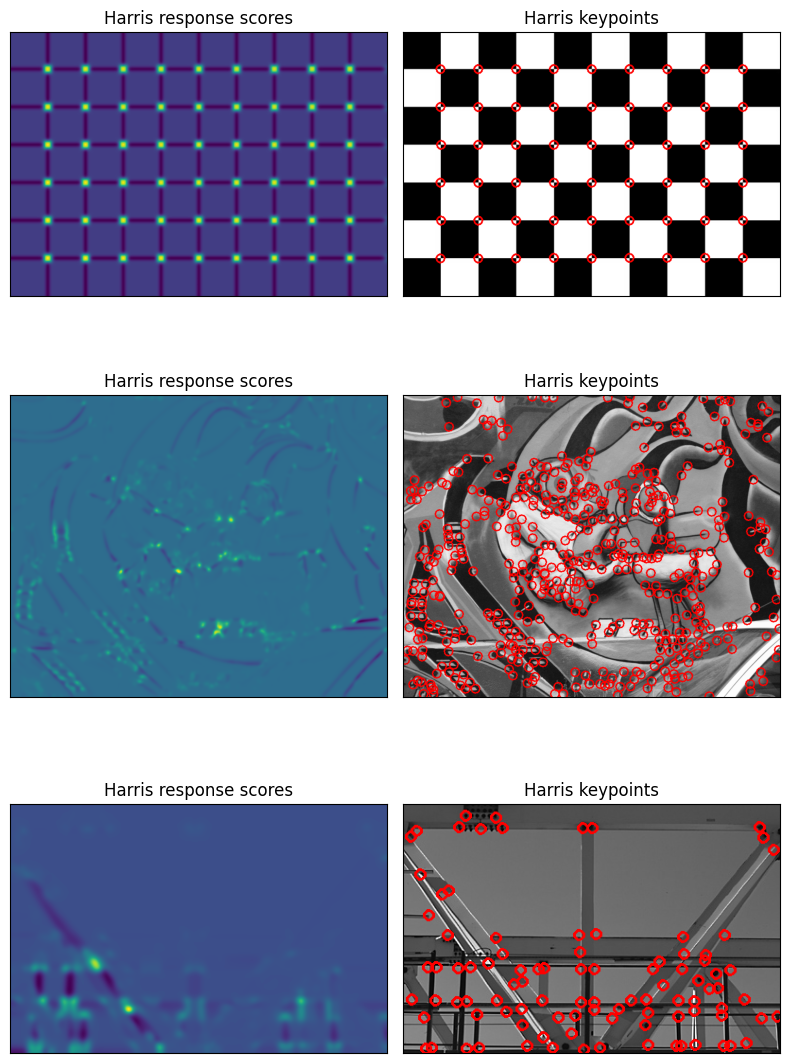

In [14]:
paths = ['checkboard.jpg', 'graf.png', 'gantrycrane.png']
images = []
titles = []
for path in paths:
    image = load_image(path)
    
    score_map = harris_scores(image, sigma1=2, sigma2=4, alpha=0.06)
    score_map_nms = nms(score_map)
    keypoints = score_map_to_keypoints(score_map_nms, score_threshold=1e-8)
    keypoint_image = draw_keypoints(image, keypoints)

    images += [score_map, keypoint_image]
    titles += ['Harris response scores', 'Harris keypoints']
plot_multiple(images, titles, max_columns=2, colormap='viridis')

## Region Descriptor Matching

Now that we can detect keypoints, we can try to match them across different images of the same object. For this we need a way to compare the neighborhood of a keypoint found in one image with the neighborhood of a keypoint found in another. If the neighborhoods are similar, then the keypoints may represent the same physical point on the object.

To compare two neighborhoods, we compute a **descriptor** vector for the image window around each keypoint and then compare these descriptors using a **distance function**.

Implement the following `compute_rgb_descriptors` function that takes a window around each point in `points` and computes a 3D RGB histogram and returns these as row vectors in a `descriptors` array.

In [24]:
# POINTS: 3

def compute_3d_histogram(im, n_bins):
    histogram = np.zeros([n_bins, n_bins, n_bins], dtype=np.float32)

    binned_im = (im * n_bins).astype(int)

    np.add.at(histogram, (binned_im[..., 0], binned_im[..., 1], binned_im[..., 2]), 1)
    histogram /= np.sum(histogram)
    
    return histogram

def compute_rgb_descriptors(rgb_im, points, win_half, n_bins):
    """For each (x,y) point in `points` calculate the 3D RGB histogram 
    descriptor and stack these into a matrix 
    of shape [num_points, descriptor_length]
    """
    descriptors = []
    rgb_im_01 = rgb_im.astype(np.float32)/256
    height, width = rgb_im.shape[:2]
    
    for (x, y) in points:
        # YOUR CODE HERE
         # Extract the window around the point (x, y)
        x1 = max(0, x - win_half)
        x2 = min(width, x + win_half + 1)
        y1 = max(0, y - win_half)
        y2 = min(height, y + win_half + 1)
        
        window = rgb_im_01[y1:y2, x1:x2]
        
        # Compute the 3D histogram for the window
        histogram = compute_3d_histogram(window, n_bins)
        
        # Flatten the histogram and append to descriptors
        descriptors.append(histogram.flatten())
        #raise NotImplementedError()

    return np.array(descriptors)

Now implement a distance computation between descriptors. The function `compute_euclidean_distances` takes descriptors that were computed for keypoints found in two different images and returns the pairwise distances between all point pairs. The result should have shape `(len(descriptors1), len(descriptors2))`.

In [25]:
# POINTS: 2

def compute_euclidean_distances(descriptors1, descriptors2):
    # YOUR CODE HERE
    # Convert descriptors to numpy arrays if they are not already
    descriptors1 = np.array(descriptors1)
    descriptors2 = np.array(descriptors2)
    
    # Initialize the distances array
    num_descriptors1 = descriptors1.shape[0]
    num_descriptors2 = descriptors2.shape[0]
    distances = np.zeros((num_descriptors1, num_descriptors2))
    
    # Compute the Euclidean distances
    for i in range(num_descriptors1):
        for j in range(num_descriptors2):
            distances[i, j] = np.linalg.norm(descriptors1[i] - descriptors2[j])
    #raise NotImplementedError()
    return distances

Given the distances, a simple way to produce point matches is to take each descriptor extracted from a keypoint of the first image, and find the keypoint in the second image with the nearest descriptor. The full pipeline from images to point matches is implemented below in the function `find_point_matches(im1, im2, opts)`.

C:\Users\lenih\AppData\Local\Temp\ipykernel_36156\2787252299.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imageio.imread('img1.jpg')
C:\Users\lenih\AppData\Local\Temp\ipykernel_36156\2787252299.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im2 = imageio.imread('img2.jpg')


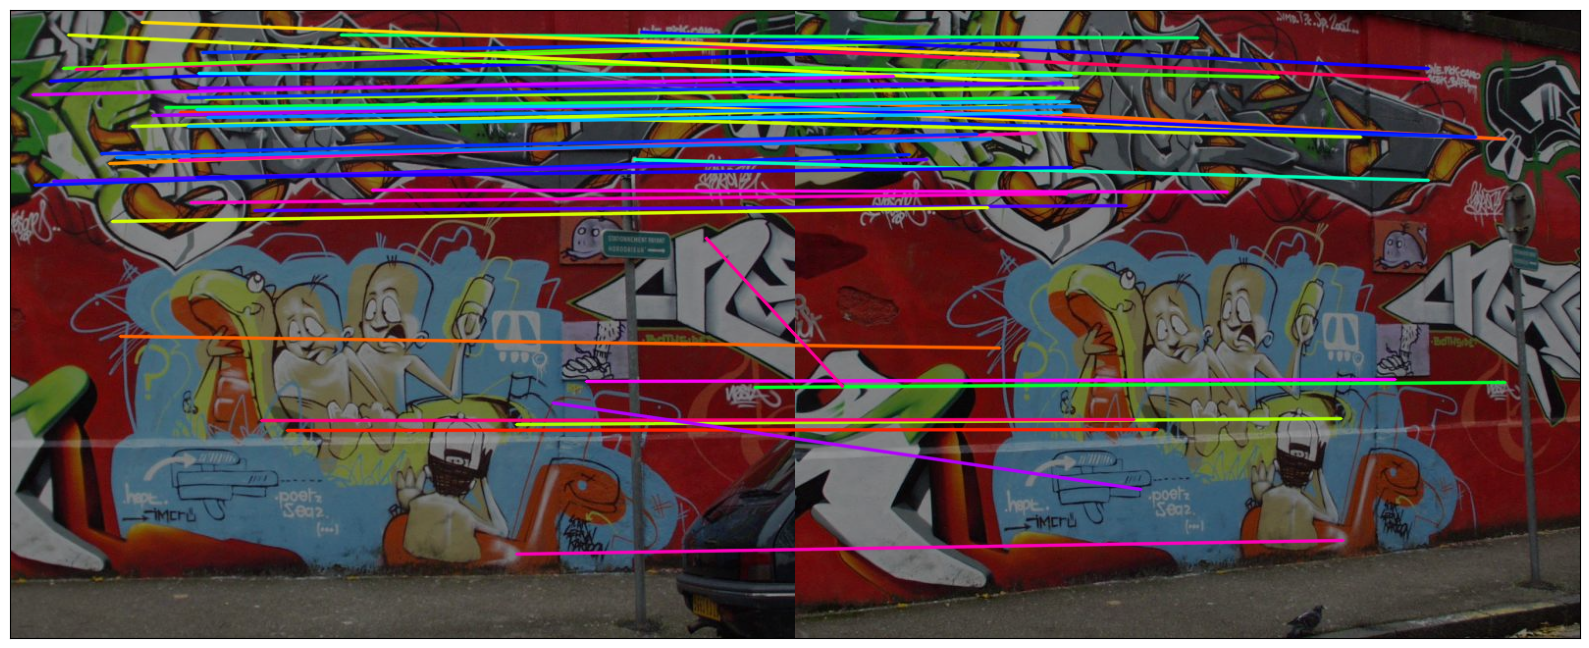

In [27]:
def find_point_matches(im1, im2, harris_kwargs, score_threshold, desc_kwargs):
    # Process first image
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY).astype(float)/255
    score_map1 = nms(harris_scores(im1_gray, **harris_kwargs))
    points1 = score_map_to_keypoints(score_map1, score_threshold)
    descriptors1 = compute_rgb_descriptors(im1, points1, **desc_kwargs)

    # Process second image independently of first
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY).astype(float)/255
    score_map2 = nms(harris_scores(im2_gray, **harris_kwargs))
    points2 = score_map_to_keypoints(score_map2, score_threshold)
    descriptors2 = compute_rgb_descriptors(im2, points2, **desc_kwargs)
    
    # Compute descriptor distances
    distances = compute_euclidean_distances(descriptors1, descriptors2)
    
    # Find the nearest neighbor of each descriptor from the first image
    # among descriptors of the second image
    closest_ids = np.argmin(distances, axis=1)
    closest_dists = np.min(distances, axis=1)
    
    # Sort the point pairs in increasing order of distance
    # (most similar ones first)
    ids1 = np.argsort(closest_dists)
    ids2 = closest_ids[ids1]
    points1 = points1[ids1]
    points2 = points2[ids2]
    
    # Stack the point matches into rows of (x1, y1, x2, y2) values
    point_matches = np.concatenate([points1, points2], axis=1)
    return point_matches

im1 = imageio.imread('img1.jpg')
im2 = imageio.imread('img2.jpg')

point_matches = find_point_matches(
    im1, im2,
    harris_kwargs={'sigma1': 2, 'sigma2': 4, 'alpha': 0.06},
    score_threshold=1e-8,
    desc_kwargs={'win_half': 20, 'n_bins': 16}
)
match_image = draw_point_matches(im1, im2, point_matches[:50])
plot_multiple([match_image], imwidth=16, imheight=8)

What do you observe?

*POINTS: 1*

YOUR ANSWER HERE

Although there are some inaccuracies in point matches, the algorithm has identified corresponding features accurately